In [52]:
using DrWatson
@quickactivate "Doran_etal_2022"
using SPI
using StatsPlots
using KernelDensity
using Random: shuffle
using Muon
using MAT

In [2]:
pdir = plotsdir("FigS6_partitioning") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/FigS6_partitioning"

In [3]:
uniprot = readh5ad(datadir("exp_pro", "UP7047", "2020_02_UP7047.h5ad"))

AnnData object 7047 ✕ 10177

In [4]:
using SparseArrays

In [5]:
mtx = sparse(uniprot.X[:,:]);

In [6]:
nnz(mtx)/(7047*10177)

0.1644447556663405

In [7]:
usv = SVD(uniprot.obsm["LSVs"][:, :], uniprot.uns["SVs"][:], uniprot.varm["RSVs"][:, :]');

In [8]:
spims = []
ints = []

Any[]

In [9]:
for q in (0:10) / 10
   push!(ints, getintervals(usv.S, alpha=1.0, q=q))
end

In [ ]:
# took ~5 hours
# spims = zeros(7047, 7047, 11);
# for (i, partitions) in enumerate(ints)
#     spims[:, :, i] .= calc_spi_mtx(usv.U, usv.S, partitions)
#     @show "\r $i/$(length(ints))"
# end

In [32]:
# spimsdiv = spims ./ 10177;

In [20]:
# matwrite(projectdir("_research", "SPImtxs_degreeofpartitioning.mat"), Dict("q$(i-1)0"=>spimsdiv[:,:,i] for i in 1:11))
spidict = matread(projectdir("_research", "SPImtxs_degreeofpartitioning.mat"))
spimsdiv = zeros(7047, 7047, 11);
for i in 0:10
    spimsdiv[:,:, i+1] .= spidict["q$(i)0"]
end

In [21]:
uppertriangle = triu(trues(size(spimsdiv[:,:,1])), 1);

In [22]:
cols = palette(:rainbow, 11).colors.colors

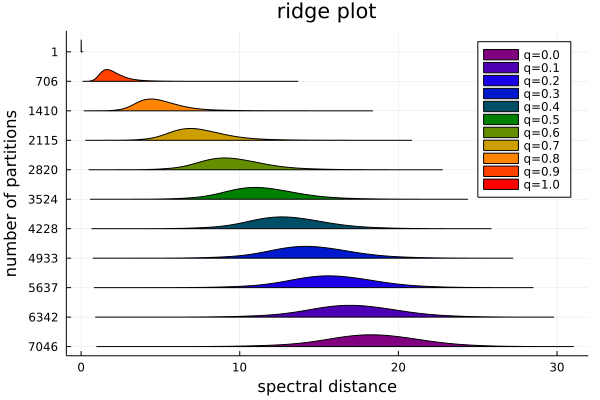

In [23]:
plot(title="ridge plot", 
    yticks=(0:10, length.(ints)),
    ylabel="number of partitions",
    xlabel="spectral distance")
for i in 1:11
    m = spimsdiv[:,:,i][uppertriangle]
    violin!([i-1], m, side=:right, c=cols[i], permute=(:x, :y), label="q=$((i-1)/10)")
end
plot!()

In [108]:
savefig(joinpath(pdir, "ridgeplot-of-spectraldistance-by-number-of-partitions.pdf"))

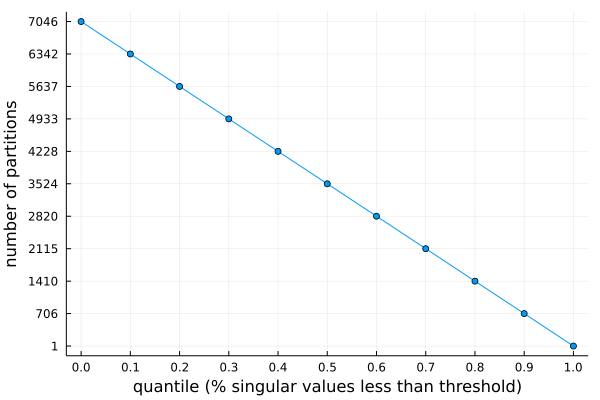

In [110]:
plot(length.(ints), 
    ylabel="number of partitions",
    xlabel="quantile (% singular values less than threshold)",
    yticks=length.(ints),
    xticks=(1:11, (0:10)/10),
    marker=true,
    label="",
    )

In [111]:
savefig(joinpath(pdir, "relationbetweennumberofpartitionsandquantile.pdf"))

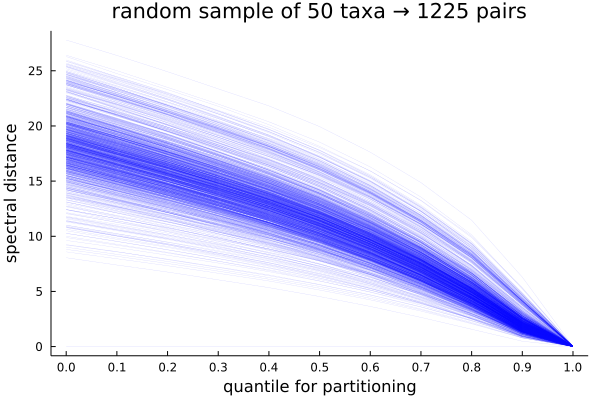

In [112]:
nsmps = 50
smpidx = rand(1:7047, nsmps)
smptriu = triu(trues(nsmps, nsmps), 1)
plotsample = mapslices(spimsdiv[smpidx, smpidx, :], dims=(1,2)) do m
    m[smptriu]
end |> x->dropdims(x, dims=2) |> permutedims

plot(title="random sample of $(nsmps) taxa → $(size(plotsample,2)) pairs",
    xticks=(1:11, (0:10)/10),
    xlabel="quantile for partitioning",
    ylabel="spectral distance",
    grid=false,
)
plot!(plotsample, label="", c=:blue, lw=.25, alpha=0.2, marker=false)

In [113]:
savefig(joinpath(pdir, "randomsampleoftaxa-spectraldistanceacrossdifferentdegreesofpartitioning.pdf"))

In [50]:
NPAIRS = binomial(7047, 2)

24826581

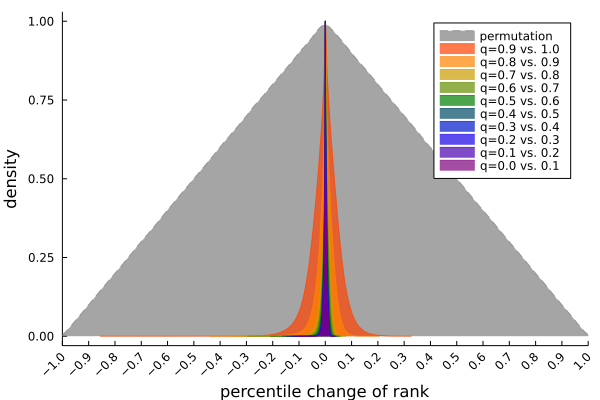

In [71]:
plot(
    # title="Distribution of rank changes when increasing partition number",
    ylabel="density",
    xlabel="percentile change of rank",
    xlims=(-1,1), 
    xticks=(-1:.1:1), 
    xrotation=45,
    grid=false,
    # fill=0,
    # alpha=.7,
)
sortrank = 1:NPAIRS
randrank = shuffle(sortrank);
density!((sortrank - randrank)/length(sortrank), c=:grey, ls=:dash, fill=0, alpha=.7, label="permutation")
for i in reverse(1:10)
    ranks0 = zeros(NPAIRS)
    ranks1 = zeros(NPAIRS)
    ranks0[sortperm(spimsdiv[:, :, i][uppertriangle])] .= (1:NPAIRS) / NPAIRS
    ranks1[sortperm(spimsdiv[:, :, i+1][uppertriangle])] .=  (1:NPAIRS) / NPAIRS
    pctchangeofrank = ranks0 .- ranks1
    k = kde(pctchangeofrank)
    plot!(k.x, k.density ./ maximum(k.density), c=cols[i], fill=0, alpha=.7, label="q=$((i-1)/10) vs. $(i/10)")
end
plot!()

In [72]:
savefig(joinpath(pdir, "relativedensity_percentilechangeofrank.pdf"))

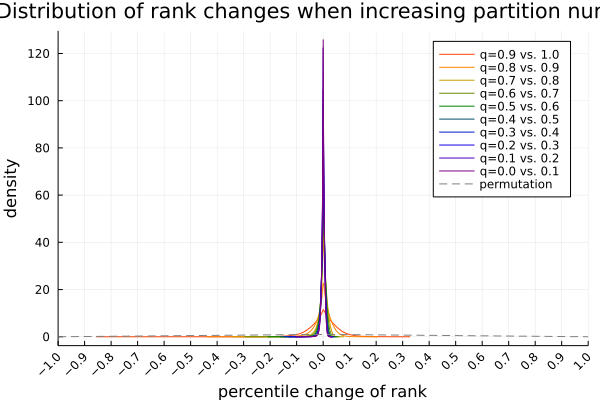

In [ ]:
plot(
    # title="Distribution of rank changes when increasing partition number",
    ylabel="density",
    xlabel="percentile change of rank",
    xlims=(-1,1), 
    xticks=(-1:.1:1), 
    xrotation=45)
for i in reverse(1:10)
    ranks0 = zeros(NPAIRS)
    ranks1 = zeros(NPAIRS)
    ranks0[sortperm(spimsdiv[:, :, i][uppertriangle])] .= (1:NPAIRS) / NPAIRS
    ranks1[sortperm(spimsdiv[:, :, i+1][uppertriangle])] .=  (1:NPAIRS) / NPAIRS
    pctchangeofrank = ranks0 .- ranks1
    density!(pctchangeofrank, c=cols[i], label="q=$((i-1)/10) vs. $(i/10)")
end
sortrank = 1:NPAIRS
randrank = shuffle(sortrank);
density!((sortrank - randrank)/length(sortrank), c=:grey, ls=:dash, label="permutation")

In [329]:
savefig(joinpath(pdir, "changeofrankbetweenquantilepartitionings.pdf"))

In [23]:
using Statistics

In [25]:
NPAIRS = binomial(7047, 2)
qs = []
for i in 1:10
    ranks0 = zeros(NPAIRS)
    ranks1 = zeros(NPAIRS)
    ranks0[sortperm(spimsdiv[:, :, i][uppertriangle])] .= (1:NPAIRS) / NPAIRS
    ranks1[sortperm(spimsdiv[:, :, i+1][uppertriangle])] .=  (1:NPAIRS) / NPAIRS
    pctchangeofrank = ranks0 .- ranks1
    push!(qs, quantile(pctchangeofrank, [.75, .875, .90, .95, .975]))
end
qs

10-element Vector{Any}:
 [0.00320773126190832, 0.005915433945576351, 0.00670716600082788, 0.00895487783839427, 0.010945566769745674]
 [0.0032204998344315117, 0.005919582724661143, 0.006708374383085691, 0.0089488762065143, 0.010939967931951677]
 [0.003640896021888773, 0.006682998355673653, 0.007574502506003555, 0.010113796982355372, 0.012367933385591685]
 [0.0038003622004979254, 0.006874043590617607, 0.007767440873151232, 0.010304439423213407, 0.01255118455497356]
 [0.004663791603040313, 0.008433944247095537, 0.009528819131397914, 0.012627795990112323, 0.015375637104440416]
 [0.0056255430419517305, 0.009929075614560072, 0.011166741002315444, 0.014649218110218243, 0.01771069483953508]
 [0.007164176170693842, 0.012525325174658541, 0.01405404956888745, 0.018350936039078447, 0.02211283140437259]
 [0.009571595863320792, 0.016395129075566228, 0.018324391908817406, 0.02373037189454319, 0.02845710007350576]
 [0.016897775815365, 0.03060912817596592, 0.03464335262273953, 0.04634210405371564, 0.05

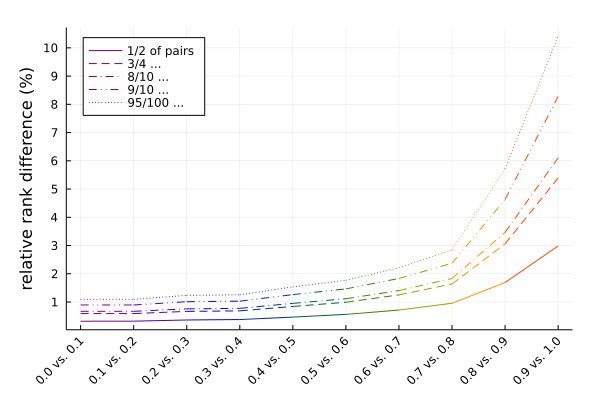

In [65]:
plot(hcat(qs...)' * 100, 
    label=["1/2 of pairs" "3/4 ..." "8/10 ..." "9/10 ..." "95/100 ..."],
    ls=[:solid :dash :dashdot :dashdotdot :dot],
    legend=:topleft, 
    # c=permutedims(palette(:rainbow, 5).colors.colors)
    c=palette(:rainbow, 10).colors.colors,
    ylabel="relative rank difference (%)",
    yticks=1:10,
    xticks=(1:10, ["$((i-1)/10) vs. $(i/10)" for i in 1:10]),
    xrotation=45,
    margin=5Plots.Measures.mm,
    )

In [66]:
savefig(joinpath(pdir, "relative-shift-of-rank-based-on-changing-threshold.pdf"))

In [58]:
t = 1.5 * quantile(abs.(diff(log.(usv.S.+1))), .75)

0.0012455625879428944

In [60]:
sum(abs.(diff(log.(usv.S.+1))) .< t) / 7046

0.8752483678682941

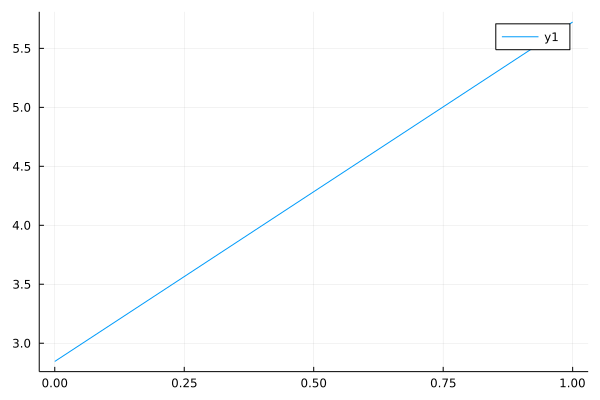

In [64]:
plot([0,1],(hcat(qs...)' * 100)[[8,9], 5])

In [69]:
.85 + (.075 * .5)

0.8875